# Task #2: Plot the profile rates per 1M residents
## A) cumulative infection rate per 1M

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter

#### Repeat the same codes in Task#1 (more details explained in previous steps)

In [2]:
# READ CUMULATIVE TABLE
covid_cumulative = pd.read_excel("covid_a_master_cumulative_table.xlsx")

last_day_per_country = covid_cumulative.groupby(by=['Countries'])['Date'].max() # type(last_day_per_country) is pandas.Series
last_day_per_country = last_day_per_country.to_frame() # We convert it to pandas.DataFrame
last_day_per_country.reset_index(inplace=True) # And reset the index so that we can further join on 'Countries'

N = 20
last_day = pd.merge(covid_cumulative, last_day_per_country, how='inner', left_on = ['Countries', 'Date'], right_on = ['Countries', 'Date'])
last_day = last_day.sort_values('Deaths', ascending=False)
top_countries = last_day[:N]['Countries'].tolist()

K = 10
covid_top_countries = covid_cumulative[covid_cumulative.Countries.isin(top_countries)]
covid_top_countries = covid_top_countries[covid_top_countries['Deaths'] > K]

day_0_for_every_country = covid_top_countries.groupby(by=['Countries']).min()
day_0_for_every_country = day_0_for_every_country['Date']

# MERGE THE TWO TO GET THE DAY_0 IN THE df, AND CALCULATE THE DAYS_FROM_0
covid_top_countries = covid_top_countries.merge(day_0_for_every_country, how='inner', on='Countries')
covid_top_countries.rename(columns = {'Date_y': 'Day_0'}, inplace = True)
covid_top_countries['Days_from_0'] = (covid_top_countries['Date_x'] - covid_top_countries['Day_0']).dt.days

#Estimate of the typical death rate per country
death_rate = pd.read_excel('Death_rate_crude_per_1000_people.xls',sheet_name='Data', header=3, 
                           index_col=0).drop(columns=['Country Code','Indicator Name','Indicator Code'])
death_rate = death_rate.ffill(axis=1).iloc[:,-1]
death_rate = death_rate.to_frame(name='Death rate per 1000')
death_rate['Countries']=death_rate.index
death_rate.replace('United States','USA', inplace=True)
death_rate.replace('United Kindom','UK', inplace=True)
death_rate.replace('Korea, Rep','S.Korea', inplace=True)
death_rate.replace('Iran, Islamic Rep.','Iran', inplace=True)
death_rate.replace('Saudi Arabia','S.Arabia', inplace=True)
death_rate.replace('South Aferica','S.Aferica', inplace=True)

df = covid_top_countries.merge(death_rate, how='left', on ='Countries')
df['Typical_deaths_per_day'] = df['Death rate per 1000']* df['Population']/1000/365
df['Typical_cumulative_deaths'] = (df['Days_from_0'] + 1)* df['Typical_deaths_per_day']
df['Excess_death_rate'] = df['Deaths'] / df['Typical_cumulative_deaths'] * 100

#### Normalizing the cases per 1 million residents is a typical procedure to get an unbiased view of the data.¶

In [3]:
df['Cases_per_1m'] = df['Cases']/df['Population']*1000000
df

,Unnamed: 0,Cases,Deaths,Date_x,Countries,Population,Continent,Day_0,Days_from_0,Death rate per 1000,Typical_deaths_per_day,Typical_cumulative_deaths,Excess_death_rate,Cases_per_1m
0,3781,61,12,2020-02-25,Iran,82913893.0,Asia,2020-02-25,0,4.835,1098.325131,1098.325131,1.092573,0.735703
1,3848,95,15,2020-02-26,Iran,82913893.0,Asia,2020-02-25,1,4.835,1098.325131,2196.650261,0.682858,1.145767
2,3915,139,19,2020-02-27,Iran,82913893.0,Asia,2020-02-25,2,4.835,1098.325131,3294.975392,0.576636,1.676438
3,3982,245,26,2020-02-28,Iran,82913893.0,Asia,2020-02-25,3,4.835,1098.325131,4393.300522,0.591810,2.954873
4,4049,388,34,2020-02-29,Iran,82913893.0,Asia,2020-02-25,4,4.835,1098.325131,5491.625653,0.619125,4.679554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,38027,607045,12987,2020-08-23,S.Africa,58558267.0,Africa,2020-04-06,139,NaN,NaN,NaN,NaN,10366.512383
3231,38236,609773,13059,2020-08-24,S.Africa,58558267.0,Africa,2020-04-06,140,NaN,NaN,NaN,NaN,10413.098461
3232,38445,611450,13159,2020-08-25,S.Africa,58558267.0,Africa,2020-04-06,141,NaN,NaN,NaN,NaN,10441.736604
3233,38654,613017,13308,2020-08-26,S.Africa,58558267.0,Africa,2020-04-06,142,NaN,NaN,NaN,NaN,10468.496276


#### Same logic we used in Section #3 (steps 12-13) to plot the 2×2 subplots with: cumulative infection rate per 1M

In [4]:
df.index.name = None
max_inf_rate = df.groupby(by=['Countries']).max()
max_inf_rate.sort_values('Cases_per_1m', ascending=False,inplace = True)
max_inf_rate.drop('Unnamed: 0', axis = 1, inplace = True)
max_inf_rate['Countries'] = max_inf_rate.index

data_1_5 = df[df.Countries.isin(max_inf_rate[:5]['Countries'].tolist())]
countries_1_5 = max_inf_rate[:5]['Countries'].tolist()
data_6_10 = df[df.Countries.isin(max_inf_rate[5:10]['Countries'].tolist())]
countries_6_10 = max_inf_rate[5:10]['Countries'].tolist()
data_11_15 = df[df.Countries.isin(max_inf_rate[10:15]['Countries'].tolist())]
countries_11_15 = max_inf_rate[10:15]['Countries'].tolist()
data_16_20 = df[df.Countries.isin(max_inf_rate[15:20]['Countries'].tolist())]
countries_16_20 = max_inf_rate[15:20]['Countries'].tolist()

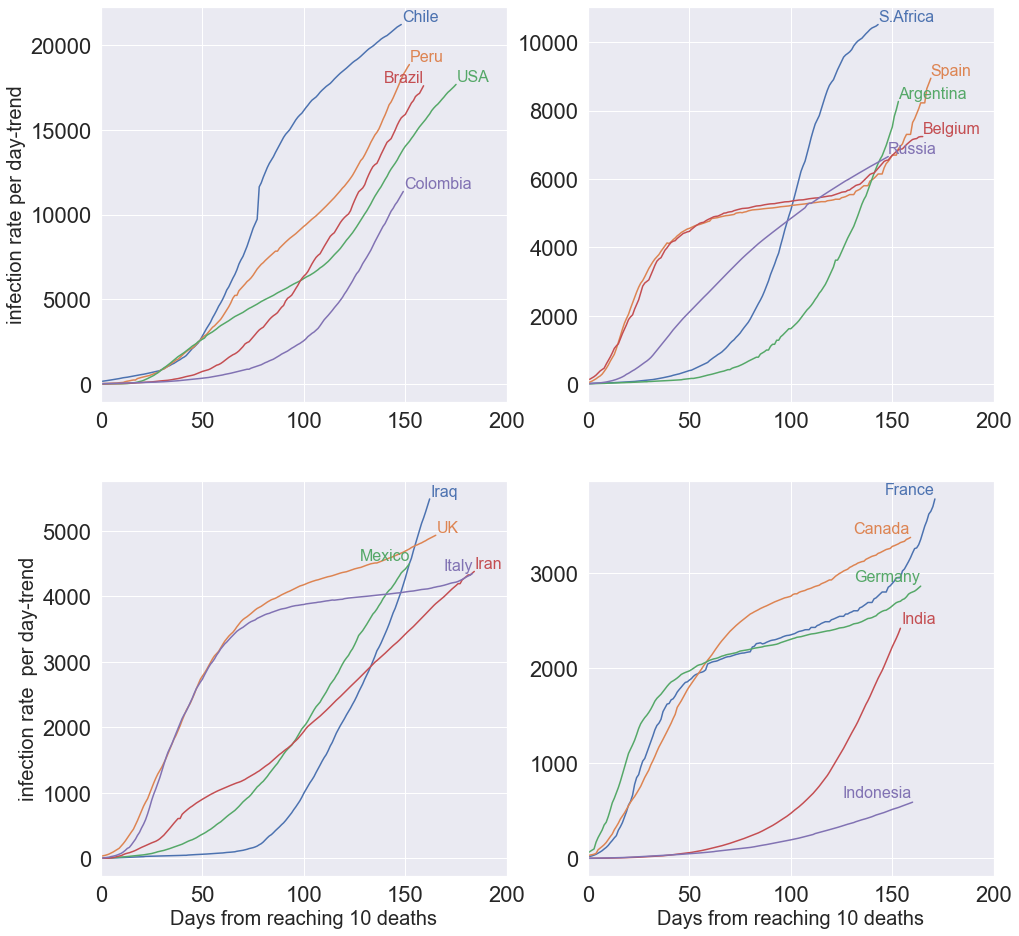

In [5]:
sns.set(rc={'figure.figsize':(16,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)

sns.lineplot(x="Days_from_0", y="Cases_per_1m", hue="Countries", data=data_1_5.reset_index(), markers=True, hue_order=countries_1_5, legend=False, ax=axes[0, 0])
texts = [axes[0, 0].text(max_inf_rate.loc[str(country)]['Days_from_0'], max_inf_rate.loc[str(country)]['Cases_per_1m'], str(country), fontsize=16, color=axes[0, 0].get_lines()[countries_1_5.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_1_5]
adjust_text(texts)
axes[0, 0].set_ylabel("infection rate per day-trend",fontsize=20)

sns.lineplot(x="Days_from_0", y="Cases_per_1m", hue="Countries", data=data_6_10.reset_index(), markers=True, hue_order=countries_6_10, legend=False, ax=axes[0, 1])
texts = [axes[0, 1].text(max_inf_rate.loc[str(country)]['Days_from_0'], max_inf_rate.loc[str(country)]['Cases_per_1m'], str(country), fontsize=16, color=axes[0, 1].get_lines()[countries_6_10.index(country)].get_c(), ha = 'left', va = 'top') for country in countries_6_10]
adjust_text(texts)

sns.lineplot(x="Days_from_0", y="Cases_per_1m", hue="Countries", data=data_11_15.reset_index(), markers=True, hue_order=countries_11_15, legend=False, ax=axes[1, 0])
texts = [axes[1, 0].text(max_inf_rate.loc[str(country)]['Days_from_0'], max_inf_rate.loc[str(country)]['Cases_per_1m'], str(country), fontsize=16, color=axes[1, 0].get_lines()[countries_11_15.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_11_15]
adjust_text(texts)
axes[1, 0].set_ylabel("infection rate  per day-trend",fontsize=20)
axes[1, 0].set_xlabel("Days from reaching 10 deaths",fontsize=20)

sns.lineplot(x="Days_from_0", y="Cases_per_1m", hue="Countries", data=data_16_20.reset_index(), markers=True, hue_order=countries_16_20, legend=False, ax=axes[1, 1])
texts = [axes[1, 1].text(max_inf_rate.loc[str(country)]['Days_from_0'], max_inf_rate.loc[str(country)]['Cases_per_1m'], str(country), fontsize=16, color=axes[1, 1].get_lines()[countries_16_20.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_16_20]
adjust_text(texts)
axes[1, 1].set_xlabel("Days from reaching 10 deaths",fontsize=20)

axes[0, 1].set_ylabel("",fontsize=24)
axes[1, 1].set_ylabel("",fontsize=24)
axes[0, 0].set_xlabel("",fontsize=24)
axes[0, 1].set_xlabel("",fontsize=24)
axes[0, 1].set_xlim([0, 200])
axes[1, 1].set_xlim([0, 200])
axes[0, 0].set_xlim([0, 200])
axes[1, 0].set_xlim([0, 200])

plt.savefig('Fig_2_1_Song_Ziruo')